

# Garbage Classification with EfficientNet and Yolo

---
## Project Description
> In this project, we aim to develop a sophisticated **garbage classification system** leveraging the **EfficientNetV2B2** architecture. Our primary dataset serves as a foundation for building models that can eventually automate waste segregation, a critical step in optimizing recycling and waste management, ultimately aiding in environmental conservation.


**Goal:** To develop an accurate and efficient garbage classification model using EfficientNetV2B2, Yolo model and transfer learning for automated waste sorting.

**Note** There is seperate file to train Yolo model in this folder






###  Core Libraries
- `tensorflow`: For deep learning model building and training.
- `numpy`: For numerical operations and array manipulation.
- `matplotlib.pyplot`: For plotting training curves and results.

In [105]:

import numpy as np  # Importing NumPy for numerical operations and array manipulations
import matplotlib.pyplot as plt  # Importing Matplotlib for plotting graphs and visualizations
import seaborn as sns  # Importing Seaborn for statistical data visualization, built on top of Matplotlib
import tensorflow as tf  # Importing TensorFlow for building and training machine learning models
from tensorflow import keras  # Importing Keras, a high-level API for TensorFlow, to simplify model building
from tensorflow.keras import Layer  # Importing Layer class for creating custom layers in Keras
from tensorflow.keras.models import Sequential  # Importing Sequential model for building neural networks layer-by-layer
from tensorflow.keras.layers import Rescaling , GlobalAveragePooling2D
from tensorflow.keras import layers, optimizers, callbacks  # Importing various modules for layers, optimizers, and callbacks in Keras
from sklearn.utils.class_weight import compute_class_weight  # Importing function to compute class weights for imbalanced datasets
from sklearn.metrics import confusion_matrix, classification_report  # Importing functions to evaluate model performance
import gradio as gr  # Importing Gradio for creating interactive web interfaces for machine learning models


from tensorflow.keras.applications import EfficientNetV2B2



In [167]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1.  Explore and Understand the Data
- Load image dataset using tools like `image_dataset_from_directory`.
- Visualize sample images from each class.
- Check the number of images per class to ensure balance.
- Understand image dimensions, color channels, and class labels.



### Load image dataset using tools like `image_dataset_from_directory`.
### Split data into training, validation, and testing sets.

`tf.keras.utils.image_dataset_from_directory(...)`  
Used to load images from a directory where each subfolder represents a class.

---

**path**  
Root directory path containing one subdirectory per class.

**shuffle=True**  
Randomly shuffles the image data. Useful during training to prevent the model from learning the order of the data.

**image_size=(224, 224)**  
Resizes all loaded images to this target size (width, height).  
This must match the input size expected by the model.

**batch_size=32**  
Number of images per batch during training.  
This affects memory usage and the frequency of model updates.



In [136]:
dataset_dir= r"/content/drive/MyDrive/Colab Notebooks/DatasetBN"
image_size = (224, 224)
batch_size = 32
seed = 42


In [137]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    shuffle = True,
    image_size=image_size,
    batch_size=batch_size
)

Found 2527 files belonging to 6 classes.
Using 2022 files for training.


In [138]:

val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    shuffle = True,
    image_size=image_size,
    batch_size=batch_size
)
val_class= val_ds.class_names

Found 2527 files belonging to 6 classes.
Using 505 files for validation.


In [139]:
# Get the total number of batches in the validation dataset
val_batches = tf.data.experimental.cardinality(val_ds)

# Split the validation dataset into two equal parts:
# First half becomes the test dataset
test_ds = val_ds.take(val_batches // 2)

# Second half remains as the validation dataset
val_dat = val_ds.skip(val_batches // 2)

# Optimize test dataset by caching and prefetching to improve performance
test_ds_eval = test_ds.cache().prefetch(tf.data.AUTOTUNE)

In [140]:

print(train_ds.class_names)
print(val_class)
print(len(train_ds.class_names))

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
6


### Visualize sample images from each class.

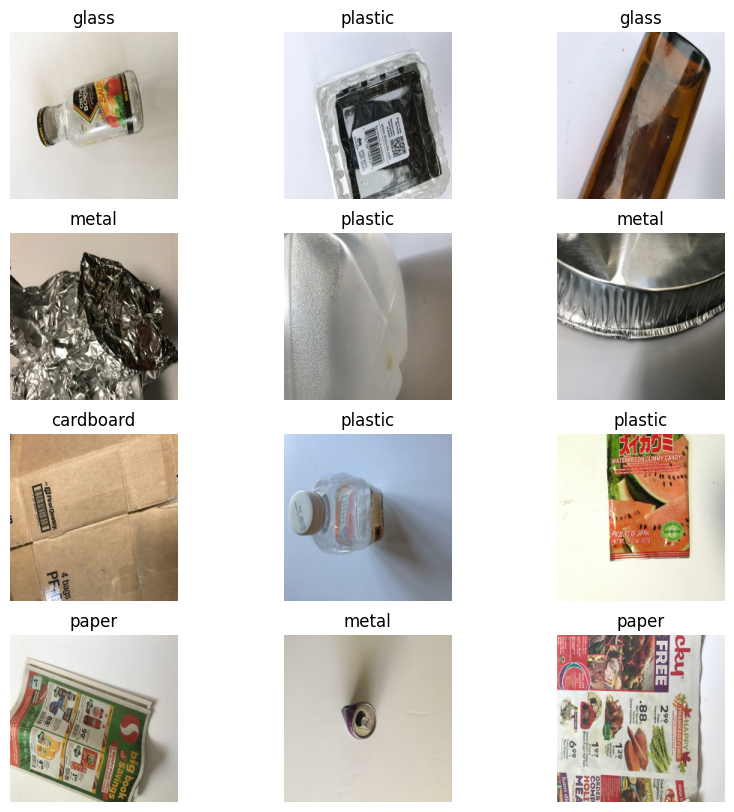

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(12):
    ax = plt.subplot(4, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

- ## Check the number of images per class to ensure balance
- ## Understand image properties like Image dimensions, Class labels


In [141]:
def count_distribution(dataset, class_names):
    total = 0
    counts = {name: 0 for name in class_names}

    for _, labels in dataset:
        for label in labels.numpy():
            class_name = class_names[label]
            counts[class_name] += 1
            total += 1

    for k in counts:
        counts[k] = round((counts[k] / total) * 100, 2)  # Convert to percentage
    return counts



In [142]:
# Function to plot class distribution
def simple_bar_plot(dist, title):
    plt.bar(dist.keys(), dist.values(), color='cornflowerblue')
    plt.title(title)
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=45)
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()


In [143]:
class_names = train_ds.class_names

# Get class distributions
train_dist = count_distribution(train_ds, class_names)
val_dist = count_distribution(val_ds, class_names)
test_dist = count_distribution(test_ds, class_names)
overall_dist = {}
for k in class_names:
    overall_dist[k] = round((train_dist[k] + val_dist[k]) / 2, 2)

print(train_dist)
print(val_dist)
print(test_dist)
print(overall_dist)

{'cardboard': 16.52, 'glass': 19.73, 'metal': 15.92, 'paper': 23.29, 'plastic': 19.44, 'trash': 5.09}
{'cardboard': 13.66, 'glass': 20.2, 'metal': 17.43, 'paper': 24.36, 'plastic': 17.62, 'trash': 6.73}
{'cardboard': 14.06, 'glass': 17.58, 'metal': 16.8, 'paper': 25.0, 'plastic': 19.14, 'trash': 7.42}
{'cardboard': 15.09, 'glass': 19.96, 'metal': 16.68, 'paper': 23.82, 'plastic': 18.53, 'trash': 5.91}


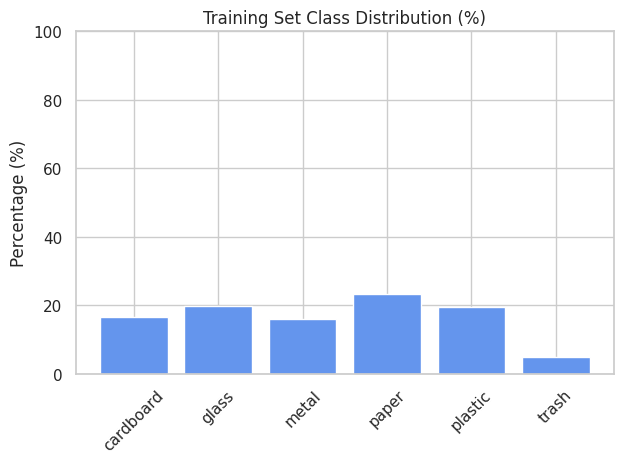

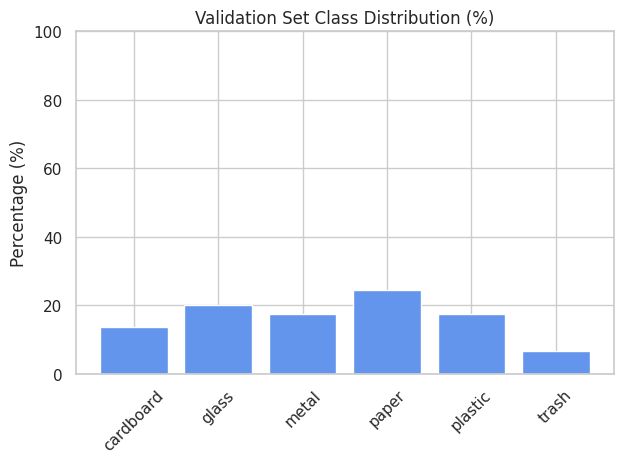

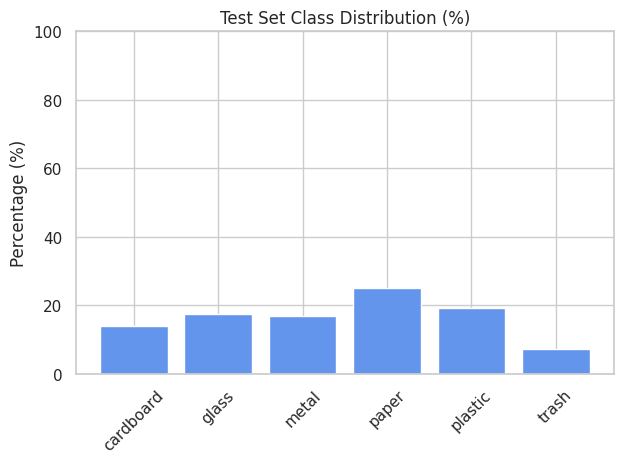

In [ ]:

# Show visualizations
simple_bar_plot(train_dist, "Training Set Class Distribution (%)")
simple_bar_plot(val_dist, "Validation Set Class Distribution (%)")
simple_bar_plot(test_dist, "Test Set Class Distribution (%)")
simple_bar_plot(overall_dist, "Overall Class Distribution (%)")


### 🛠️ Addressing Imbalance Using Class Weights:

To tackle our imbalanced image dataset, we'll utilize **class weights**. These weights assign more importance to underrepresented classes during training. The weights are computed inversely proportional to class frequencies using utilities like `compute_class_weight` from **scikit-learn**, based on the distribution of images in each class. The formula is:

$$
\text{weight(class)} = \frac{\text{total samples}}{\text{number of classes} \times \text{samples in that class}}
$$

These computed weights are then passed to the model.


In [ ]:


# Count class occurrences and prepare label list
class_counts = {i: 0 for i in range(len(class_names))}
all_labels = []

for images, labels in train_ds:
    for label in labels.numpy():
        class_counts[label] += 1
        all_labels.append(label)

# Compute class weights (index aligned)
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(class_names)),
    y=all_labels
)

# Create dictionary mapping class index to weight
class_weights = {i: w for i, w in enumerate(class_weights_array)}


In [ ]:

# ✅ Optional: print results
print("Class Counts:", class_counts)
print("Class Weights:", class_weights)


In [ ]:
#  Define data augmentation pipeline
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])


## 3.  Model Selection
- Choose a base model: Custom CNN or Transfer Learning (e.g., `EfficientNetV2B2`).
- Decide whether to use pre-trained weights (e.g., ImageNet).
- Define whether layers should be trainable or frozen during initial training.

In [119]:
base_model = EfficientNetV2B2(include_top=False, input_shape=(224, 224, 3),include_preprocessing=True, weights='imagenet')


 # Freeze early layers (to retain general pretrained features)
base_model.trainable = True
for layer in base_model.layers[:100]:  # You can adjust this number
    layer.trainable = False

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step



## 4.  Model Training
- Build the model architecture using `Sequential` or Functional API.
- Compile the model with loss function ( `sparse_categorical_crossentropy`), optimizer (e.g., `Adam`), and evaluation metrics (`accuracy`).

## 5.  Model Tuning and Optimization
- Tune hyperparameters: learning rate, batch size, number of layers, dropout rate.
- Use callbacks: `EarlyStopping`,
- Optionally perform fine-tuning on pre-trained models by unfreezing some layers.

### Model Architecture and Layer Utilities

- **Sequential**: A simple way to build models by stacking layers one after the other in a linear fashion.

- **RandomFlip**: A data augmentation layer that flips input images horizontally or vertically at random, helping the model generalize better.

- **RandomRotation**: Randomly rotates images by a specified angle range during training to make the model invariant to orientation.

- **RandomZoom**: Applies random zoom-in or zoom-out to training images, helping the model recognize objects at various scales.

- **Dropout**: A regularization method that randomly "drops" (sets to zero) a fraction of input units during training to prevent overfitting.

- **GlobalAveragePooling2D**: Reduces each feature map to a single number by taking the average, reducing model parameters and helping prevent overfitting.

- **Dense**: A fully connected neural network layer used to learn complex features and typically found at the end of the model for classification.

- **Input**: Specifies the input shape and data type for the model; acts as the starting point of the model architecture.

- **EfficientNetV2B2**: A pre-trained convolutional neural network from the EfficientNetV2 family, known for being lightweight and high-performing, commonly used for transfer learning.


In [148]:
#  Build the final model for effiecientnet
model = Sequential([
    layers.Input(shape=(224, 224, 3)),
   data_augmentation,
    base_model,
    GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(6, activation='softmax')  # Change to your number of classes
])


In [149]:
# ⚙️ Compile the model
from tensorflow.keras.optimizers import AdamW


model.compile(
    optimizer=optimizers.AdamW(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


### 🔁 Callbacks
- `EarlyStopping`: To stop training when validation performance stops improving

In [150]:
# Define an EarlyStopping callback to stop training when validation loss stops improving
early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',            # Metric to monitor (validation loss here)
    patience=3,                   # Number of epochs to wait after last improvement before stopping
    restore_best_weights=True     # After stopping, restore the model weights from the epoch with the best val_loss
)


### Train the model using `.fit()` with appropriate `epochs`, `batch_size`, and callbacks like `EarlyStopping`.

In [151]:
# Set the number of epochs to train the model
epochs = 30  # Number of times the model will go through the entire dataset

 #Train the model using the fit function
history = model.fit(
    train_ds,                # Training dataset used to adjust model weights
    validation_data=val_ds,   # Validation dataset to monitor performance on unseen data
    epochs=epochs,           # Number of training cycles, referencing the variable set earlier
    class_weight=class_weights,  # Handles class imbalances by assigning appropriate weights
    batch_size=32,           # Number of samples processed in each training step
    callbacks=[early]         # Implements early stopping to prevent unnecessary training
)

Epoch 1/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 69s 321ms/step - accuracy: 0.5755 - loss: 1.1967 - val_accuracy: 0.9248 - val_loss: 0.2713
Epoch 2/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 225ms/step - accuracy: 0.9615 - loss: 0.2065 - val_accuracy: 0.9446 - val_loss: 0.2148
Epoch 3/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 19s 202ms/step - accuracy: 0.9810 - loss: 0.1085 - val_accuracy: 0.9347 - val_loss: 0.2169
Epoch 4/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 21s 206ms/step - accuracy: 0.9804 - loss: 0.0805 - val_accuracy: 0.9465 - val_loss: 0.1950
Epoch 5/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 199ms/step - accuracy: 0.9777 - loss: 0.0790 - val_accuracy: 0.9465 - val_loss: 0.1963
Epoch 6/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 218ms/step - accuracy: 0.9877 - loss: 0.0488 - val_accuracy: 0.9426 - val_loss: 0.1869
Epoch 7/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 20s 205ms/step - accuracy: 0.9874 - loss: 0.0499 - val_accuracy: 0.9386 - val_loss: 0.1977
Epoch 8/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 21s 217ms/step - accuracy: 0.9886 - loss: 0.0449 - val_accu

In [152]:
# 📝 Summary (optional but useful)
model.summary()


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_6 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │         7,686 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,253,668 (62.00 MB)

 Trainable params: 5,163,334 (19.70 MB)

 Non-trainable params: 763,664 (2.91 MB)

 Optimizer params: 10,326,670 (39.39 MB)

In [153]:
base_model.summary() # Print the architecture summary of the base model

Model: "efficientnetv2-b0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 224, 224,  │          0 │ input_layer_7[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 224, 224,  │          0 │ rescaling_3[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ normalization_1[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 112, 112,  │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 56, 56,    │      9,216 │ block1a_project_… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 56, 56,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 56, 56,    │          0 │ block2a_expand_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, 56, 56,    │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, 56, 56,    │        128 │ block2a_project_… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_conv │ (None, 56, 56,    │     36,864 │ block2a_project_… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_bn   │ (None, 56, 56,    │        512 │ block2b_expand_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_act… │ (None, 56, 56,    │          0 │ block2b_expand_b

 Total params: 5,919,312 (22.58 MB)

 Trainable params: 5,155,648 (19.67 MB)

 Non-trainable params: 763,664 (2.91 MB)

# Model Performance Visualization: Accuracy & Loss Trends

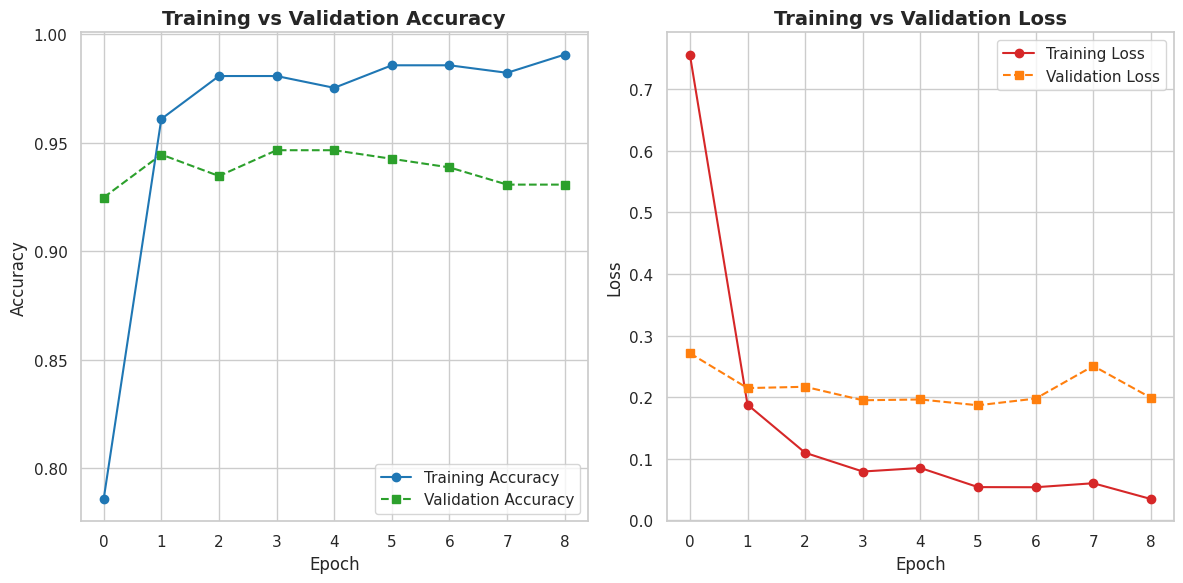

In [154]:

# Use a seaborn style
sns.set_style("whitegrid")

# Extract history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

# Create figure and subplots
plt.figure(figsize=(12, 6))

# Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, marker='o', linestyle='-', color='tab:blue', label='Training Accuracy')
plt.plot(epochs_range, val_acc, marker='s', linestyle='--', color='tab:green', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(loc='lower right')
plt.grid(True)

# Loss subplot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, marker='o', linestyle='-', color='tab:red', label='Training Loss')
plt.plot(epochs_range, val_loss, marker='s', linestyle='--', color='tab:orange', label='Validation Loss')
plt.title('Training vs Validation Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()


In [155]:
loss, accuracy = model.evaluate(test_ds_eval)
print(f'Test accuracy is{accuracy:.4f}, Test loss is {loss:.4f}')

final_accuracy_percent = accuracy * 100
print(f"Final Test Accuracy: {final_accuracy_percent:.2f}%")


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.9462 - loss: 0.1695
Test accuracy is0.9414, Test loss is 0.1818
Final Test Accuracy: 94.14%


In [156]:
y_true = np.concatenate([y.numpy() for x, y in test_ds_eval], axis=0)
y_pred_probs = model.predict(test_ds_eval)
y_pred = np.argmax(y_pred_probs, axis=1)


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step


In [157]:
# Extract true labels from all batches in the test dataset
y_true = np.concatenate([y.numpy() for x, y in test_ds_eval], axis=0)  # Convert Tensor labels to NumPy array and concatenate them

# Get predictions as probabilities from the model
y_pred_probs = model.predict(test_ds_eval)  # Predict class probabilities for each sample in the test dataset

# Convert probabilities to predicted class indices
y_pred = np.argmax(y_pred_probs, axis=1)  # Select the class with the highest probability for each sample

# Compute the confusion matrix to evaluate classification performance
cm = confusion_matrix(y_true, y_pred)  # Generate confusion matrix comparing true labels to predicted labels

# Print metrics to assess model performance
print(cm)  # Display confusion matrix
print(classification_report(y_true, y_pred))  # Print precision, recall, and F1-score for each class


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step
[[35  0  0  2  0  0]
 [ 0 50  4  0  2  0]
 [ 0  1 36  0  0  0]
 [ 2  0  0 60  0  0]
 [ 1  1  1  0 39  1]
 [ 0  0  0  0  0 21]]
              precision    recall  f1-score   support

           0       0.92      0.95      0.93        37
           1       0.96      0.89      0.93        56
           2       0.88      0.97      0.92        37
           3       0.97      0.97      0.97        62
           4       0.95      0.91      0.93        43
           5       0.95      1.00      0.98        21

    accuracy                           0.94       256
   macro avg       0.94      0.95      0.94       256
weighted avg       0.94      0.94      0.94       256



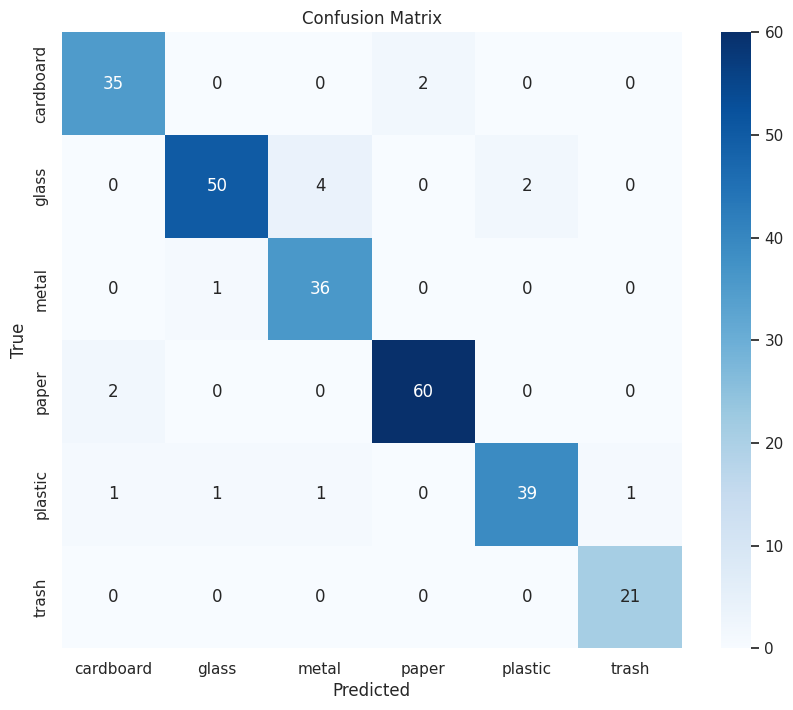

In [158]:
plt.figure(figsize=(10,8))  # Set figure size for better visualization

sns.heatmap(cm, annot=True, fmt='d',  # Create heatmap using confusion matrix
            xticklabels=class_names,  # Set class names for x-axis (predicted labels)
            yticklabels=class_names,  # Set class names for y-axis (true labels)
            cmap='Blues')  # Use a blue colormap for better contrast

plt.xlabel('Predicted')  # Label x-axis as Predicted classes
plt.ylabel('True')  # Label y-axis as True classes
plt.title('Confusion Matrix')  # Add title to the heatmap
plt.show()  # Display the plot

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


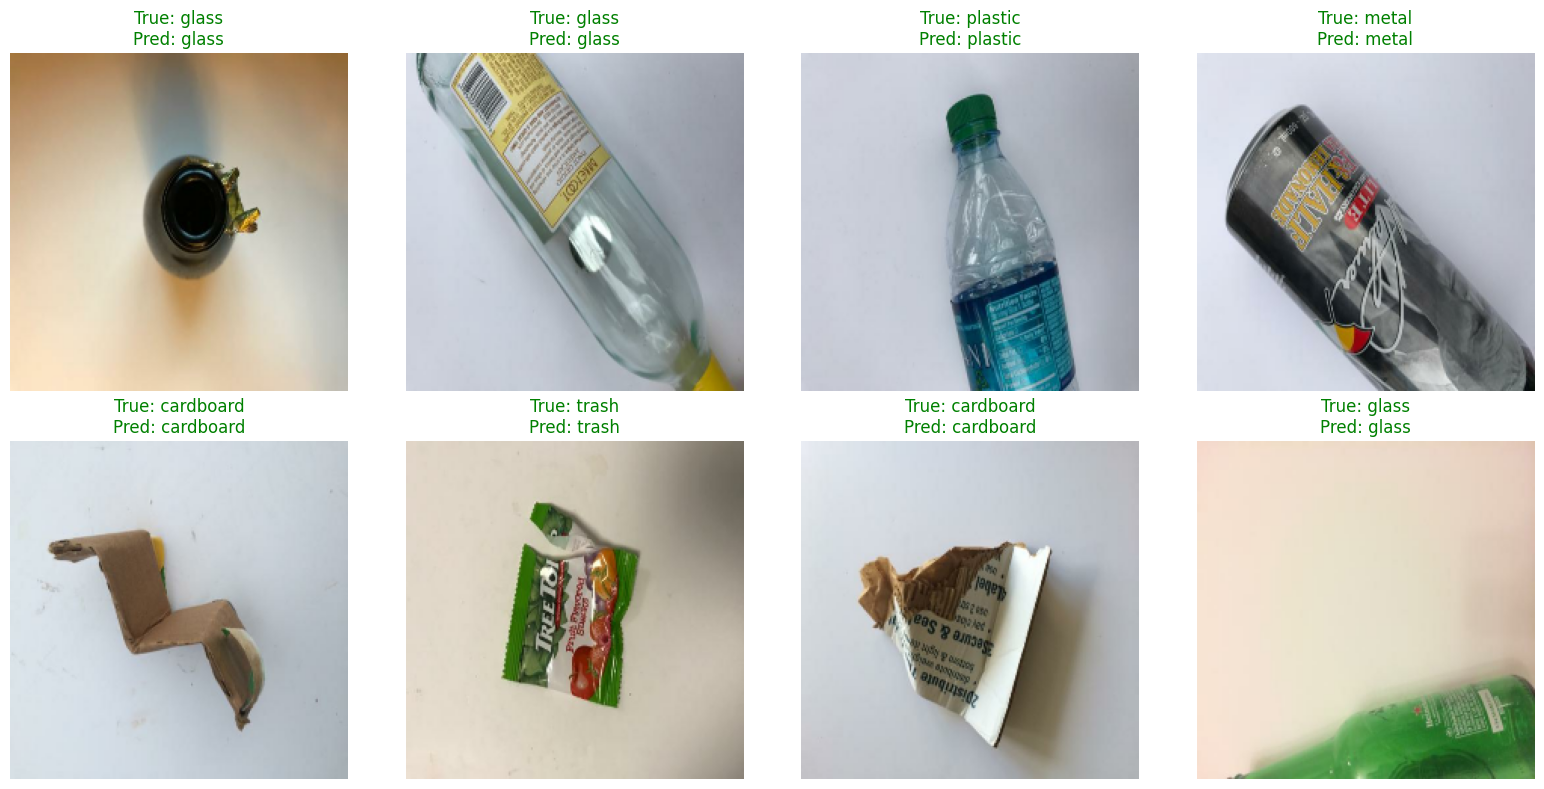

In [159]:

# Extract class names
class_names = train_ds.class_names

# Take one batch from the test dataset
for images, labels in test_ds_eval.take(1):
    predictions = model.predict(images)
    pred_labels = tf.argmax(predictions, axis=1)

    # Create a 2x4 subplot grid
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))  # 2 rows, 4 columns

    for i in range(8):
        ax = axes[i // 4, i % 4]  # Row = i//4, Column = i%4
        ax.imshow(images[i].numpy().astype("uint8"))
        true_label = class_names[labels[i]]
        pred_label = class_names[pred_labels[i]]
        ax.set_title(f"True: {true_label}\nPred: {pred_label}", fontsize=12, color='green' if true_label == pred_label else 'red')
        ax.axis('off')

    plt.tight_layout()
    plt.show()


**Final Testing and Saving the Model**

In [160]:
# Save model in Keras format with architecture, weights, and training configuration
model.save('224EffiecientnetV2B2n.keras')

 #Load your Keras model
model = tf.keras.models.load_model('224EffiecientnetV2B2n.keras')

Shows Missclassified images to check if there are any images saved in wrong class which is causing problems (ex- glass image is saved in paper)

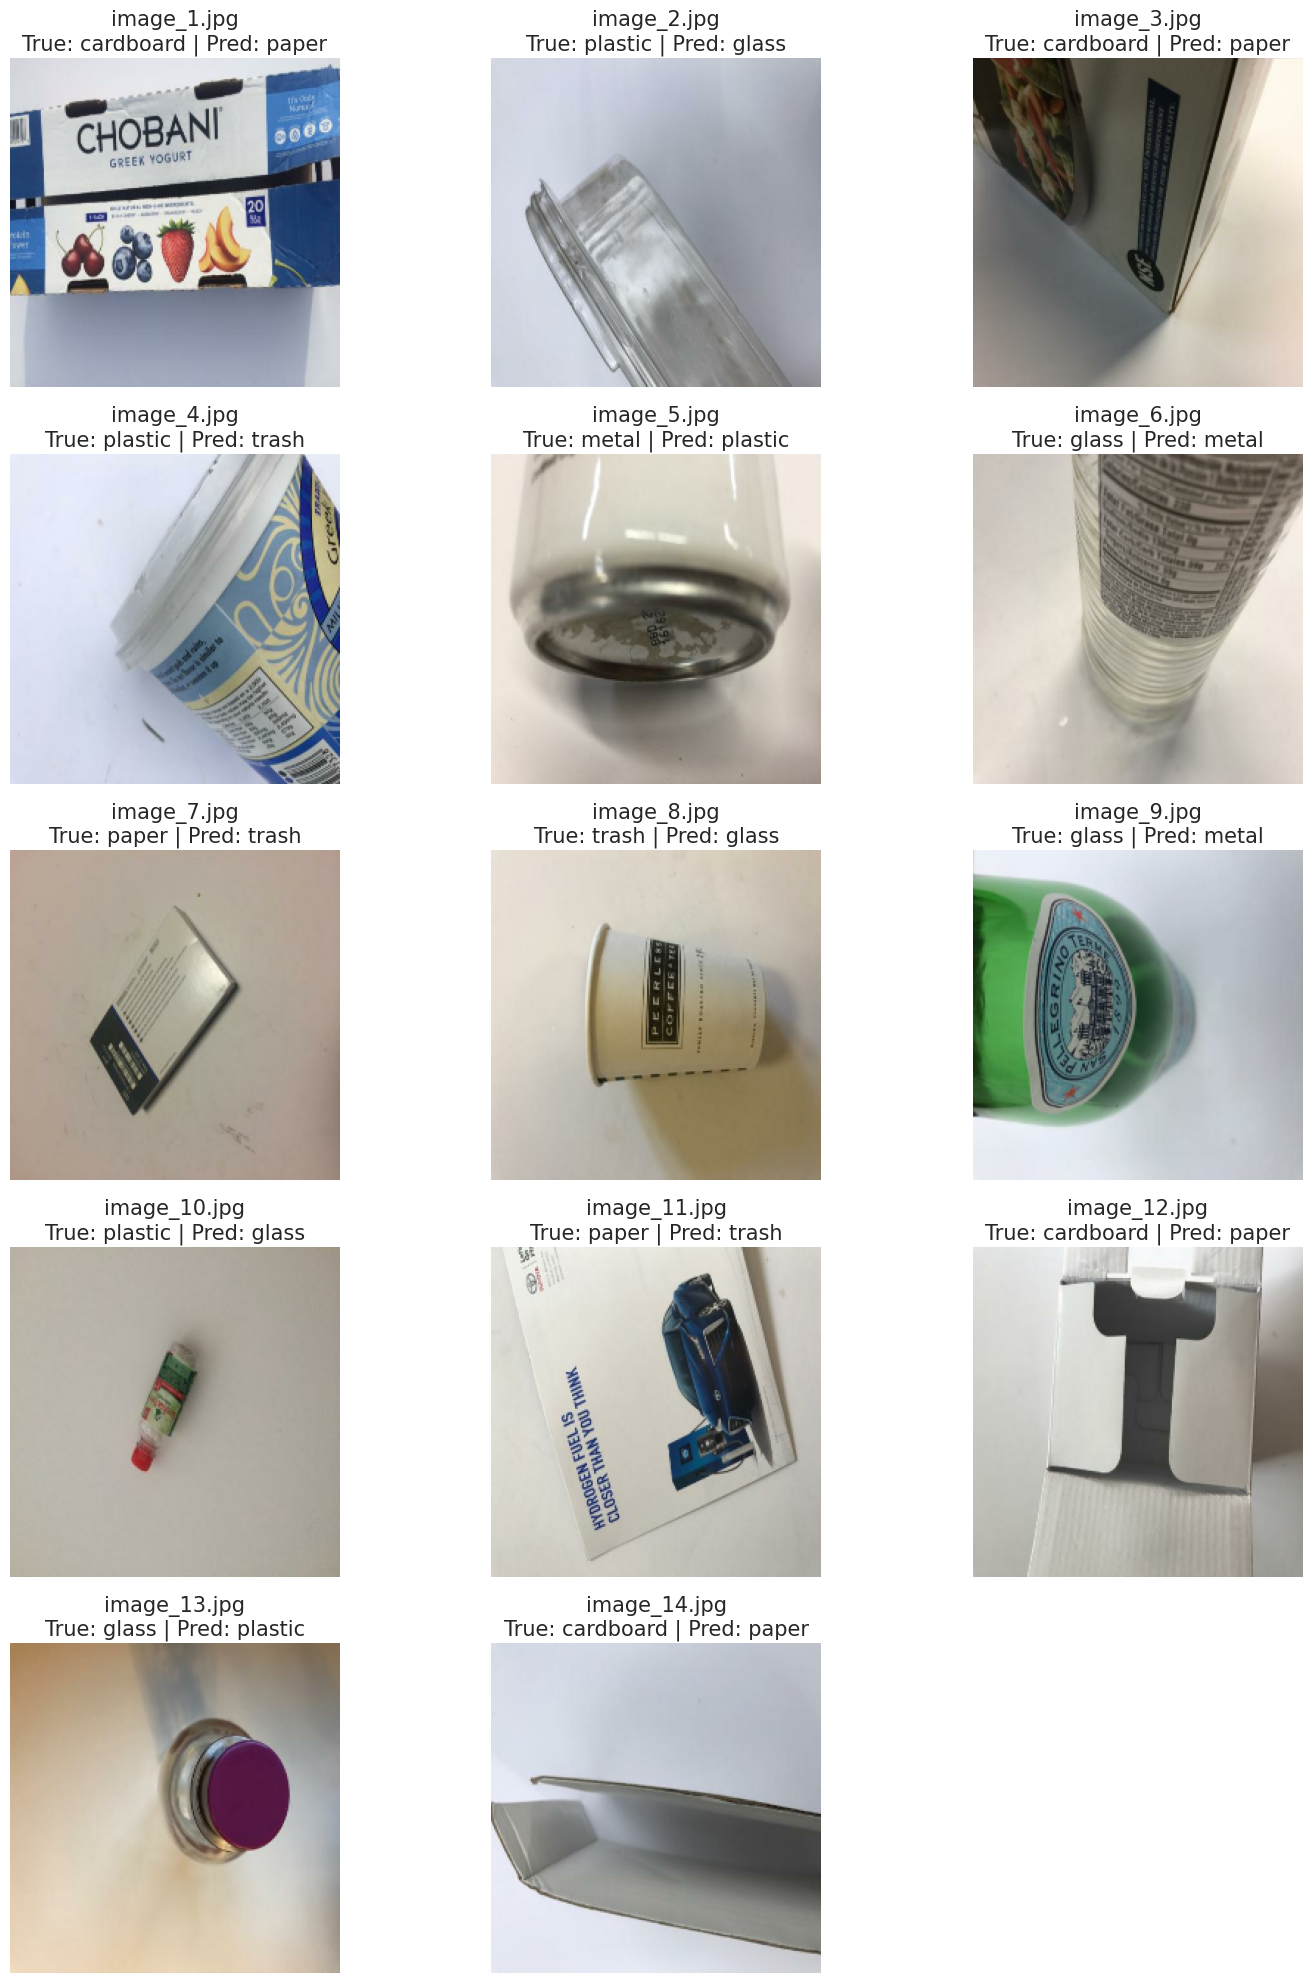

In [161]:
import matplotlib.pyplot as plt
import math
import os

total = len(misclassified_images)
cols = 3
rows = math.ceil(total / cols)

plt.figure(figsize=(15, rows * 4))
for i in range(total):
    ax = plt.subplot(rows, cols, i + 1)
    plt.imshow(misclassified_images[i].astype("uint8"))

    true_lbl = class_names[true_labels[i]]
    pred_lbl = class_names[pred_labels_list[i]]
    filename = os.path.basename(misclassified_files[i])

    ax.set_title(f"{filename}\nTrue: {true_lbl} | Pred: {pred_lbl}", fontsize=15)
    plt.axis("off")

plt.tight_layout()
plt.show()


In [162]:
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

In [163]:
def classify_image(img):
    # Resize image to 224x224 pixels
    img = img.resize((224, 224))

    # Convert image to a NumPy array with float32 dtype
    img_array = np.array(img, dtype=np.float32)
    img_array = preprocess_input(img_array)

    # Expand dimensions to match model input shape (adds a batch dimension)
    img_array = np.expand_dims(img_array, axis=0)

    # Make a prediction using the trained model
    prediction = model.predict(img_array)

    # Get the index of the highest predicted probability
    predicted_class_index = np.argmax(prediction)

    # Map the predicted index to its corresponding class name
    predicted_class_name = class_names[predicted_class_index]

    # Extract confidence score (probability of the predicted class)
    confidence = prediction[0][predicted_class_index]

    # Return formatted prediction result with confidence score
    return f"Predicted: {predicted_class_name} (Confidence: {confidence:.2f})"

Preview on Gradio interface (final Gradio

In [165]:
iface = gr.Interface(
    fn=classify_image,  # Function to classify image using the trained model
    inputs=gr.Image(type="pil"),  # Accepts input as a PIL image
    outputs="text"  # Outputs prediction as text
)

# Launch the interface
iface.launch()  # Start the Gradio interface for user interaction

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://8ed0ab1e9ba28fcce8.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## Conclusion

The image classification model demonstrates strong accuracy in identifying objects, leveraging deep learning to refine predictions effectively. Its robust performance ensures reliable classification, making it a valuable tool for various applications.


**Check the yolo file for yolo training method**

Final App Deployed on gradio [https://huggingface.co/spaces/xayane006/imageclassify](https://huggingface.co/spaces/xayane006/imageclassify)